In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal Length M=20000


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
min_a, max_a = .2, .4
min_sr, max_sr = 5., 6.5
min_g, max_g = .2, .4
min_ri, max_ri = .001, 5.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .4)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./MG_Saved_Models/MG_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** 10 ***********
Iter: 0 #### Diagnostic 1.320   Time 9.33  Best 1000.000 NRMSE 0.342 CD 0.978
Iter: 1 #### Diagnostic 1000.000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.077   Time 5.13  Best 1000.000 NRMSE 0.250 CD 0.827
Iter: 3 #### Diagnostic 1.724   Time 5.09  Best 1000.000 NRMSE 0.375 CD 1.349
Iter: 4 #### Diagnostic 1000.000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 5.12  Best 1000.000 NRMSE 34471998976241438720.000 CD 1.000
Iter: 8 #### Diagnostic 1000.000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.046   Time 5.12  Best 1000.000 NRMSE 0.232 CD 0.814
Iter: 11 #### Diagnostic 1000.000   Time 5.11  Best 1000.000 NRMSE 

Iter: 0 #### Diagnostic 1.037   Time 5.09  Best 1000.000 NRMSE 0.257 CD 0.780
Iter: 1 #### Diagnostic 1000.000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 0.898   Time 5.06  Best 1000.000 NRMSE 0.191 CD 0.707
Iter: 3 #### Diagnostic 1.051   Time 5.08  Best 1000.000 NRMSE 0.230 CD 0.820
Iter: 4 #### Diagnostic 1000.000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 5.07  Best 1000.000 NRMSE 170701241544424384.000 CD 1.205
Iter: 6 #### Diagnostic 0.961   Time 5.10  Best 1000.000 NRMSE 0.197 CD 0.764
Iter: 7 #### Diagnostic 1000.000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.890   Time 5.07  Best 1000.000 NRMSE 0.212 CD 0.679
Iter: 9 #### Diagnostic 1.277   Time 5.11  Best 1000.000 NRMSE 0.298 CD 0.979
Iter: 10 #### Diagnostic 1000.000   Time 5.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.039   Time 5.08  Best 1000.000 NRMSE 0.215 CD 0.824
Iter: 12 #### Diagnostic 1

Iter: 0 #### Diagnostic 1000.000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.199   Time 5.09  Best 1000.000 NRMSE 0.270 CD 0.930
Iter: 2 #### Diagnostic 1000.000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.282   Time 5.09  Best 1000.000 NRMSE 0.317 CD 0.966
Iter: 4 #### Diagnostic 1.046   Time 5.20  Best 1000.000 NRMSE 0.217 CD 0.829
Iter: 5 #### Diagnostic 1.180   Time 5.10  Best 1000.000 NRMSE 0.266 CD 0.914
Iter: 6 #### Diagnostic 0.712   Time 5.09  Best 1000.000 NRMSE 0.204 CD 0.509
Iter: 7 #### Diagnostic 0.477   Time 5.13  Best 1000.000 NRMSE 0.156 CD 0.321
Iter: 8 #### Diagnostic 1000.000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.103   Time 5.11  Best 1000.000 NRMSE 0.264 CD 0.839
Iter: 10 #### Diagnostic 0.784   Time 5.10  Best 1000.000 NRMSE 0.200 CD 0.584
Iter: 11 #### Diagnostic 0.980   Time 5.07  Best 1000.000 NRMSE 0.203 CD 0.777
Iter: 12 #### Diagnostic 1.375   Time 5.12  Best 1

Iter: 0 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 9.406   Time 6.54  Best 1000.000 NRMSE 8.300 CD 1.106
Iter: 2 #### Diagnostic 1000.000   Time 6.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.847   Time 5.21  Best 1000.000 NRMSE 0.189 CD 0.658
Iter: 4 #### Diagnostic 1.190   Time 5.14  Best 1000.000 NRMSE 0.228 CD 0.962
Iter: 5 #### Diagnostic 1.052   Time 5.21  Best 1000.000 NRMSE 0.388 CD 0.665
Iter: 6 #### Diagnostic 1.401   Time 5.15  Best 1000.000 NRMSE 0.263 CD 1.138
Iter: 7 #### Diagnostic 1.430   Time 5.32  Best 1000.000 NRMSE 0.315 CD 1.115
Iter: 8 #### Diagnostic 0.827   Time 5.29  Best 1000.000 NRMSE 0.188 CD 0.640
Iter: 9 #### Diagnostic 1.331   Time 6.17  Best 1000.000 NRMSE 0.218 CD 1.114
Iter: 10 #### Diagnostic 1.406   Time 5.67  Best 1000.000 NRMSE 0.296 CD 1.110
Iter: 11 #### Diagnostic 1000.000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.118   Time 5.29  Best 1

Iter: 0 #### Diagnostic 1.259   Time 5.25  Best 1000.000 NRMSE 0.241 CD 1.018
Iter: 1 #### Diagnostic 1000.000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.937   Time 5.13  Best 1000.000 NRMSE 0.233 CD 0.704
Iter: 4 #### Diagnostic 1.064   Time 5.09  Best 1000.000 NRMSE 0.230 CD 0.834
Iter: 5 #### Diagnostic 0.988   Time 5.21  Best 1000.000 NRMSE 0.196 CD 0.792
Iter: 6 #### Diagnostic 1.414   Time 5.12  Best 1000.000 NRMSE 0.384 CD 1.030
Iter: 7 #### Diagnostic 0.929   Time 5.11  Best 1000.000 NRMSE 0.194 CD 0.735
Iter: 8 #### Diagnostic 0.963   Time 5.17  Best 1000.000 NRMSE 0.195 CD 0.768
Iter: 9 #### Diagnostic 1000.000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.069   Time 5.68

Iter: 0 #### Diagnostic 1.109   Time 5.52  Best 1000.000 NRMSE 0.217 CD 0.892
Iter: 1 #### Diagnostic 1000.000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 5.050   Time 5.45  Best 1000.000 NRMSE 3.961 CD 1.088
Iter: 3 #### Diagnostic 0.984   Time 5.42  Best 1000.000 NRMSE 0.288 CD 0.696
Iter: 4 #### Diagnostic 1.136   Time 5.38  Best 1000.000 NRMSE 0.237 CD 0.899
Iter: 5 #### Diagnostic 0.929   Time 5.51  Best 1000.000 NRMSE 0.194 CD 0.735
Iter: 6 #### Diagnostic 1.223   Time 5.42  Best 1000.000 NRMSE 0.268 CD 0.956
Iter: 7 #### Diagnostic 0.980   Time 5.35  Best 1000.000 NRMSE 0.203 CD 0.777
Iter: 8 #### Diagnostic 1.227   Time 5.34  Best 1000.000 NRMSE 0.265 CD 0.962
Iter: 9 #### Diagnostic 1.260   Time 5.35  Best 1000.000 NRMSE 0.282 CD 0.978
Iter: 10 #### Diagnostic 1000.000   Time 5.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.661   Time 5.38  Best 1

Iter: 0 #### Diagnostic 0.983   Time 5.50  Best 1000.000 NRMSE 0.201 CD 0.782
Iter: 1 #### Diagnostic 0.836   Time 5.48  Best 1000.000 NRMSE 0.219 CD 0.617
Iter: 2 #### Diagnostic 1.169   Time 5.40  Best 1000.000 NRMSE 0.216 CD 0.952
Iter: 3 #### Diagnostic 1.014   Time 5.48  Best 1000.000 NRMSE 0.210 CD 0.803
Iter: 4 #### Diagnostic 1.155   Time 5.51  Best 1000.000 NRMSE 0.239 CD 0.917
Iter: 5 #### Diagnostic 0.829   Time 5.47  Best 1000.000 NRMSE 0.202 CD 0.627
Iter: 6 #### Diagnostic 1.023   Time 5.46  Best 1000.000 NRMSE 0.209 CD 0.813
Iter: 7 #### Diagnostic 0.991   Time 5.48  Best 1000.000 NRMSE 0.197 CD 0.795
Iter: 8 #### Diagnostic 1.129   Time 5.44  Best 1000.000 NRMSE 0.216 CD 0.912
Iter: 9 #### Diagnostic 1.483   Time 5.47  Best 1000.000 NRMSE 0.266 CD 1.218
Iter: 10 #### Diagnostic 1.342   Time 5.50  Best 1000.000 NRMSE 0.277 CD 1.065
Iter: 11 #### Diagnostic 1000.000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.009   Time 5.45  Best 1000.000 

Iter: 0 #### Diagnostic 0.971   Time 5.58  Best 1000.000 NRMSE 0.196 CD 0.775
Iter: 1 #### Diagnostic 1.585   Time 5.59  Best 1000.000 NRMSE 0.304 CD 1.282
Iter: 2 #### Diagnostic 1.317   Time 6.41  Best 1000.000 NRMSE 0.276 CD 1.040
Iter: 3 #### Diagnostic 1.299   Time 5.54  Best 1000.000 NRMSE 0.327 CD 0.972
Iter: 4 #### Diagnostic 1.163   Time 5.50  Best 1000.000 NRMSE 0.259 CD 0.904
Iter: 5 #### Diagnostic 1.534   Time 5.51  Best 1000.000 NRMSE 0.637 CD 0.898
Iter: 6 #### Diagnostic 1000.000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 0.988   Time 5.61  Best 1000.000 NRMSE 0.231 CD 0.757
Iter: 8 #### Diagnostic 1000.000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.488   Time 5.50  Best 1000.000 NRMSE 0.292 CD 1.195
Iter: 11 #### Diagnostic 1000.000   Time 5.44  Best 1000.000 NRMSE 13054894131078252544.000 CD 1.000
Iter: 12 #### Diagnostic 1.3

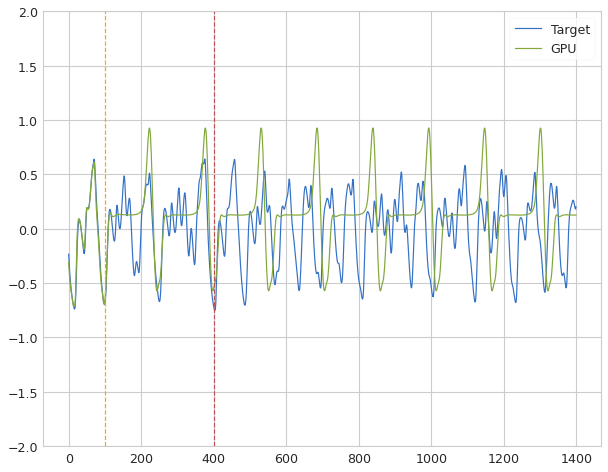

 Iter=89 a=0.257 sr=6.264 amp=0.290  ri=4.330 rr=2.415 loss=0.396886


Iter: 89 #### Diagnostic 0.397   Time 5.86  Best 0.397 NRMSE 0.145 CD 0.252
Iter: 90 #### Diagnostic 1000.000   Time 5.46  Best 0.397 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000   Time 5.51  Best 0.397 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 0.654   Time 5.43  Best 0.397 NRMSE 0.188 CD 0.466
Iter: 93 #### Diagnostic 0.982   Time 5.56  Best 0.397 NRMSE 0.200 CD 0.782
Iter: 94 #### Diagnostic 1000.000   Time 5.43  Best 0.397 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000   Time 5.49  Best 0.397 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.048   Time 5.71  Best 0.397 NRMSE 0.207 CD 0.840
Iter: 97 #### Diagnostic 1.066   Time 5.59  Best 0.397 NRMSE 0.218 CD 0.848
Iter: 98 #### Diagnostic 1000.000   Time 5.70  Best 0.397 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.175   Time 5.62  Best 0.397 NRMSE 0.243 CD 0.932

Best result = 0.39688625089542184
a = 0.25687017592000183
sr = 6.2641228

Iter: 89 #### Diagnostic 1.251   Time 5.50  Best 1000.000 NRMSE 0.295 CD 0.956
Iter: 90 #### Diagnostic 1000.000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 0.823   Time 5.83  Best 1000.000 NRMSE 0.187 CD 0.636
Iter: 92 #### Diagnostic 1.253   Time 5.44  Best 1000.000 NRMSE 0.240 CD 1.012
Iter: 93 #### Diagnostic 1000.000   Time 5.53  Best 1000.000 NRMSE 49546187372182414648991656477458432.000 CD 1.000
Iter: 94 #### Diagnostic 1.071   Time 5.40  Best 1000.000 NRMSE 0.211 CD 0.860
Iter: 95 #### Diagnostic 1.452   Time 5.50  Best 1000.000 NRMSE 0.301 CD 1.151
Iter: 96 #### Diagnostic 1.010   Time 5.51  Best 1000.000 NRMSE 0.199 CD 0.811
Iter: 97 #### Diagnostic 1.050   Time 5.56  Best 1000.000 NRMSE 0.230 CD 0.820
Iter: 98 #### Diagnostic 1.093   Time 5.55  Best 1000.000 NRMSE 0.212 CD 0.881
Iter: 99 #### Diagnostic 0.875   Time 5.41  Best 1000.000 NRMSE 0.194 CD 0.681

Best result = 0.7395181329236271
a = 0.20620837971275818
sr = 5.9332048571522025
amp = 0.

Iter: 87 #### Diagnostic 1.120   Time 5.52  Best 1000.000 NRMSE 0.229 CD 0.892
Iter: 88 #### Diagnostic 1000.000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.074   Time 5.55  Best 1000.000 NRMSE 0.209 CD 0.865
Iter: 90 #### Diagnostic 0.915   Time 5.51  Best 1000.000 NRMSE 0.193 CD 0.722
Iter: 91 #### Diagnostic 1.020   Time 5.54  Best 1000.000 NRMSE 0.213 CD 0.807
Iter: 92 #### Diagnostic 0.443   Time 5.49  Best 1000.000 NRMSE 0.161 CD 0.283
Iter: 93 #### Diagnostic 1000.000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.916   Time 5.62  Best 1000.000 NRMSE 0.243 CD 0.673
Iter: 95 #### Diagnostic 1.204   Time 5.55  Best 1000.000 NRMSE 0.218 CD 0.986
Iter: 96 #### Diagnostic 1000.000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.105   Time 5.56  Best 1000.000 NRMSE 0.213 CD 0.892
Iter: 98 #### Diagnostic 0.884   Time 5.62  Best 1000.000 NRMSE 0.192 CD 0.692
Iter: 99 #### Diagnostic 1000.000   Time

Iter: 79 #### Diagnostic 1000.000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.787   Time 5.54  Best 1000.000 NRMSE 0.335 CD 1.451
Iter: 83 #### Diagnostic 1000.000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.343   Time 5.48  Best 1000.000 NRMSE 0.286 CD 1.057
Iter: 85 #### Diagnostic 1.303   Time 5.67  Best 1000.000 NRMSE 0.278 CD 1.025
Iter: 86 #### Diagnostic 1.240   Time 5.67  Best 1000.000 NRMSE 0.215 CD 1.025
Iter: 87 #### Diagnostic 1.034   Time 5.52  Best 1000.000 NRMSE 0.230 CD 0.804
Iter: 88 #### Diagnostic 1.075   Time 5.77  Best 1000.000 NRMSE 0.290 CD 0.786
Iter: 89 #### Diagnostic 1.240   Time 5.60  Best 1000.000 NRMSE 0.290 CD 0.950
Iter: 90 #### Diagnostic 1.061   Time 5.79  Best 1000.000 NRMSE 0.231 CD 0.830
Iter: 91 #### Diagnostic 1000.000   

Iter: 79 #### Diagnostic 1000.000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.402   Time 5.45  Best 1000.000 NRMSE 0.264 CD 1.138
Iter: 81 #### Diagnostic 0.516   Time 5.55  Best 1000.000 NRMSE 0.156 CD 0.360
Iter: 82 #### Diagnostic 1.585   Time 5.47  Best 1000.000 NRMSE 0.346 CD 1.239
Iter: 83 #### Diagnostic 1000.000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.042   Time 5.60  Best 1000.000 NRMSE 0.215 CD 0.827
Iter: 85 #### Diagnostic 1.580   Time 5.49  Best 1000.000 NRMSE 0.301 CD 1.279
Iter: 86 #### Diagnostic 0.854   Time 5.52  Best 1000.000 NRMSE 0.191 CD 0.663
Iter: 87 #### Diagnostic 1000.000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.219   Time 5.50  Best 1000.000 NRMSE 0.222 CD 0.997
Iter: 90 #### Diagnostic 1.118   Time 5.51  Best 1000.000 NRMSE 0.214 CD 0.904
Iter: 91 #### Diagnostic 1.269   Tim

Iter: 79 #### Diagnostic 1000.000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.042   Time 5.56  Best 1000.000 NRMSE 0.238 CD 0.804
Iter: 81 #### Diagnostic 0.992   Time 5.63  Best 1000.000 NRMSE 0.203 CD 0.788
Iter: 82 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 570528667321632817152.000 CD 1.000
Iter: 83 #### Diagnostic 0.468   Time 5.48  Best 1000.000 NRMSE 0.154 CD 0.314
Iter: 84 #### Diagnostic 1000.000   Time 5.56  Best 1000.000 NRMSE 42709.857 CD 0.806
Iter: 85 #### Diagnostic 1000.000   Time 6.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 0.756   Time 5.58  Best 1000.000 NRMSE 0.188 CD 0.568
Iter: 87 #### Diagnostic 1000.000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1.259   Time 5.53  Best 1000.000 NRMSE 0.261 CD 0.998
Iter: 89 #### Diagnostic 1.299   Time 5.65  Best 1000.000 NRMSE 0.260 CD 1.039
Iter: 90 #### Diagnostic 1.175   Time 5.57  Best 1000.000 NRMSE 0.227 CD 0.948
Iter: 91 #

Iter: 77 #### Diagnostic 1000.000   Time 8.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.495   Time 8.38  Best 1000.000 NRMSE 0.289 CD 1.206
Iter: 79 #### Diagnostic 1.033   Time 7.29  Best 1000.000 NRMSE 0.229 CD 0.804
Iter: 80 #### Diagnostic 1000.000   Time 9.70  Best 1000.000 NRMSE 60388380383.444 CD 0.716
Iter: 81 #### Diagnostic 1.083   Time 7.39  Best 1000.000 NRMSE 0.211 CD 0.872
Iter: 82 #### Diagnostic 1000.000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.486   Time 10.15  Best 1000.000 NRMSE 0.601 CD 0.884
Iter: 84 #### Diagnostic 0.900   Time 9.73  Best 1000.000 NRMSE 0.202 CD 0.698
Iter: 85 #### Diagnostic 0.907   Time 7.21  Best 1000.000 NRMSE 0.205 CD 0.702
Iter: 86 #### Diagnostic 0.793   Time 6.78  Best 1000.000 NRMSE 0.207 CD 0.587
Iter: 87 #### Diagnostic 0.506   Time 5.53  Best 1000.000 NRMSE 0.159 CD 0.346
Iter: 88 #### Diagnostic 0.905   Time 5.50  Best 1000.000 NRMSE 0.219 CD 0.686
Iter: 89 #### Diagnostic 1000.

Iter: 76 #### Diagnostic 1.041   Time 11.57  Best 1000.000 NRMSE 0.204 CD 0.838
Iter: 77 #### Diagnostic 1000.000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.692   Time 7.71  Best 1000.000 NRMSE 0.189 CD 0.503
Iter: 79 #### Diagnostic 1000.000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.045   Time 7.48  Best 1000.000 NRMSE 0.268 CD 0.777
Iter: 81 #### Diagnostic 1000.000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 9.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 8.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.616   Time 6.95  Best 1000.000 NRMSE 0.324 CD 1.292
Iter: 85 #### Diagnostic 0.866   Time 5.39  Best 1000.000 NRMSE 0.256 CD 0.610
Iter: 86 #### Diagnostic 0.828   Time 5.20  Best 1000.000 NRMSE 0.186 CD 0.642
Iter: 87 #### Diagnostic 0.915   Time 5.22  Best 1000.000 NRMSE 0.226 CD 0.689
Iter: 88 #### Diagnostic 1000.0

Iter: 71 #### Diagnostic 1.380   Time 8.51  Best 1000.000 NRMSE 0.303 CD 1.076
Iter: 72 #### Diagnostic 1.114   Time 7.78  Best 1000.000 NRMSE 0.212 CD 0.901
Iter: 73 #### Diagnostic 1.194   Time 7.10  Best 1000.000 NRMSE 0.259 CD 0.935
Iter: 74 #### Diagnostic 1000.000   Time 7.55  Best 1000.000 NRMSE 4237583558913914891665408.000 CD 1.000
Iter: 75 #### Diagnostic 1.267   Time 8.14  Best 1000.000 NRMSE 0.263 CD 1.004
Iter: 76 #### Diagnostic 1000.000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.886   Time 8.31  Best 1000.000 NRMSE 0.192 CD 0.694
Iter: 78 #### Diagnostic 1.119   Time 7.05  Best 1000.000 NRMSE 0.259 CD 0.860
Iter: 79 #### Diagnostic 1000.000   Time 9.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 7.53  Best 1000.000 NRMSE 490353837195.474 CD 1.251
Iter: 82 #### Diagnostic 1.303   Time 9.18  Best 1000.000 NRMSE 0.274 CD 1.029

Iter: 69 #### Diagnostic 1000.000   Time 7.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.150   Time 7.28  Best 1000.000 NRMSE 0.220 CD 0.930
Iter: 72 #### Diagnostic 0.688   Time 7.12  Best 1000.000 NRMSE 0.179 CD 0.509
Iter: 73 #### Diagnostic 1000.000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.053   Time 7.10  Best 1000.000 NRMSE 0.208 CD 0.845
Iter: 75 #### Diagnostic 1000.000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 0.973   Time 7.33  Best 1000.000 NRMSE 0.201 CD 0.772
Iter: 77 #### Diagnostic 1.197   Time 9.24  Best 1000.000 NRMSE 0.251 CD 0.946
Iter: 78 #### Diagnostic 1.033   Time 7.34  Best 1000.000 NRMSE 0.239 CD 0.794
Iter: 79 #### Diagnostic 1.080   Time 7.31  Best 1000.000 NRMSE 0.231 CD 0.849
Iter: 80 #### Diagnostic 0.901   Time 7.69  Best 1000.000 NRMSE 0.206 CD 0.695
Iter: 81 #### Diagnostic 1000.000   

Iter: 69 #### Diagnostic 1000.000   Time 7.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.748   Time 7.23  Best 1000.000 NRMSE 0.209 CD 0.539
Iter: 71 #### Diagnostic 1000.000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.155   Time 7.61  Best 1000.000 NRMSE 0.220 CD 0.935
Iter: 74 #### Diagnostic 0.964   Time 7.25  Best 1000.000 NRMSE 0.213 CD 0.751
Iter: 75 #### Diagnostic 1000.000   Time 6.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.030   Time 8.27  Best 1000.000 NRMSE 0.268 CD 0.762
Iter: 77 #### Diagnostic 1.141   Time 7.27  Best 1000.000 NRMSE 0.236 CD 0.904
Iter: 78 #### Diagnostic 1000.000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.449   Time 7.73  Best 1000.000 NRMSE 0.273 CD 1.176
Iter: 80 #### Diagnostic 0.888   Time 7.92  Best 1000.000 NRMSE 0.196 CD 0.692
Iter: 81 #### Diagnostic 0.998  

Iter: 67 #### Diagnostic 1.246   Time 5.64  Best 1000.000 NRMSE 0.248 CD 0.998
Iter: 68 #### Diagnostic 1.197   Time 5.52  Best 1000.000 NRMSE 0.240 CD 0.957
Iter: 69 #### Diagnostic 1.415   Time 5.49  Best 1000.000 NRMSE 0.251 CD 1.165
Iter: 70 #### Diagnostic 1.101   Time 5.61  Best 1000.000 NRMSE 0.212 CD 0.889
Iter: 71 #### Diagnostic 1000.000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 5.61  Best 1000.000 NRMSE 220872309.699 CD 1.243
Iter: 73 #### Diagnostic 1.066   Time 5.62  Best 1000.000 NRMSE 0.239 CD 0.827
Iter: 74 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Dia

Iter: 67 #### Diagnostic 1.063   Time 5.44  Best 1000.000 NRMSE 0.222 CD 0.841
Iter: 68 #### Diagnostic 1000.000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.225   Time 5.46  Best 1000.000 NRMSE 0.246 CD 0.979
Iter: 73 #### Diagnostic 1.271   Time 5.51  Best 1000.000 NRMSE 0.304 CD 0.967
Iter: 74 #### Diagnostic 1.034   Time 5.49  Best 1000.000 NRMSE 0.203 CD 0.831
Iter: 75 #### Diagnostic 1.353   Time 5.51  Best 1000.000 NRMSE 0.284 CD 1.069
Iter: 76 #### Diagnostic 1000.000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic

Iter: 63 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.383   Time 5.57  Best 1000.000 NRMSE 0.268 CD 1.115
Iter: 65 #### Diagnostic 1000.000   Time 5.47  Best 1000.000 NRMSE 1110958485726728.750 CD 0.785
Iter: 66 #### Diagnostic 1000.000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.212   Time 5.52  Best 1000.000 NRMSE 0.236 CD 0.976
Iter: 69 #### Diagnostic 1000.000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.142   Time 5.56  Best 1000.000 NRMSE 0.254 CD 0.888
Iter: 72 #### Diagnostic 0.986   Time 5.50  Best 1000.000 NRMSE 0.205 CD 0.781
Iter: 73 #### Diagnostic 1.011   Time 5.53  Best 1000.000 NRMSE 0.208 CD 0.803
Iter: 74 #### Diagnostic 1000.000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #

Iter: 63 #### Diagnostic 1000.000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.016   Time 5.38  Best 1000.000 NRMSE 0.204 CD 0.812
Iter: 65 #### Diagnostic 1.271   Time 5.47  Best 1000.000 NRMSE 0.257 CD 1.014
Iter: 66 #### Diagnostic 1.454   Time 5.41  Best 1000.000 NRMSE 0.377 CD 1.076
Iter: 67 #### Diagnostic 1000.000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.965   Time 5.85  Best 1000.000 NRMSE 0.262 CD 0.703
Iter: 69 #### Diagnostic 1.132   Time 5.46  Best 1000.000 NRMSE 0.214 CD 0.919
Iter: 70 #### Diagnostic 1000.000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.580   Time 5.54  Best 1000.000 NRMSE 0.407 CD 1.173
Iter: 73 #### Diagnostic 1.013   Time 5.46  Best 1000.000 NRMSE 0.204 CD 0.810
Iter: 74 #### Diagnostic 1.093   Time 5.45  Best 1000.000 NRMSE 0.225 CD 0.868
Iter: 75 #### Diagnostic 1000.000   

Iter: 62 #### Diagnostic 1.467   Time 5.40  Best 1000.000 NRMSE 0.264 CD 1.202
Iter: 63 #### Diagnostic 1000.000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.073   Time 5.46  Best 1000.000 NRMSE 0.262 CD 0.812
Iter: 65 #### Diagnostic 1.291   Time 5.43  Best 1000.000 NRMSE 0.271 CD 1.020
Iter: 66 #### Diagnostic 0.908   Time 5.48  Best 1000.000 NRMSE 0.193 CD 0.716
Iter: 67 #### Diagnostic 1.211   Time 5.43  Best 1000.000 NRMSE 0.269 CD 0.943
Iter: 68 #### Diagnostic 0.973   Time 5.45  Best 1000.000 NRMSE 0.200 CD 0.773
Iter: 69 #### Diagnostic 1.016   Time 5.43  Best 1000.000 NRMSE 0.225 CD 0.791
Iter: 70 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.061   Time 5.40  Best 1000.000 NRMSE 0.230 CD 0.831
Iter: 72 #### Diagnostic 1.226   Time 5.32  Best 1000.000 NRMSE 0.257 CD 0.969
Iter: 73 #### Diagnostic 1.089   Time 5.41  Best 1000.000 NRMSE 0.240 CD 0.849
Iter: 74 #### Diagnostic 1000.000   Time 5.4

Iter: 61 #### Diagnostic 1.596   Time 5.36  Best 1000.000 NRMSE 0.656 CD 0.940
Iter: 62 #### Diagnostic 1.476   Time 5.33  Best 1000.000 NRMSE 0.276 CD 1.200
Iter: 63 #### Diagnostic 1000.000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.313   Time 5.39  Best 1000.000 NRMSE 0.250 CD 1.063
Iter: 66 #### Diagnostic 1.626   Time 5.40  Best 1000.000 NRMSE 0.315 CD 1.312
Iter: 67 #### Diagnostic 1000.000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.277   Time 5.46  Best 1000.000 NRMSE 0.227 CD 1.050
Iter: 69 #### Diagnostic 1.096   Time 5.38  Best 1000.000 NRMSE 0.236 CD 0.860
Iter: 70 #### Diagnostic 1.232   Time 5.38  Best 1000.000 NRMSE 0.259 CD 0.973
Iter: 71 #### Diagnostic 1.237   Time 5.40  Best 1000.000 NRMSE 0.251 CD 0.986
Iter: 72 #### Diagnostic 1000.000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   

Iter: 61 #### Diagnostic 1000.000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.108   Time 5.36  Best 1000.000 NRMSE 0.225 CD 0.883
Iter: 63 #### Diagnostic 1000.000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.240   Time 5.42  Best 1000.000 NRMSE 0.227 CD 1.013
Iter: 65 #### Diagnostic 0.767   Time 5.34  Best 1000.000 NRMSE 0.185 CD 0.582
Iter: 66 #### Diagnostic 1000.000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.075   Time 5.29  Best 1000.000 NRMSE 0.211 CD 0.864
Iter: 68 #### Diagnostic 0.959   Time 5.35  Best 1000.000 NRMSE 0.222 CD 0.737
Iter: 69 #### Diagnostic 1.513   Time 5.29  Best 1000.000 NRMSE 0.332 CD 1.181
Iter: 70 #### Diagnostic 1.432   Time 5.66  Best 1000.000 NRMSE 0.319 CD 1.113
Iter: 71 #### Diagnostic 0.974   Time 5.37  Best 1000.000 NRMSE 0.201 CD 0.773
Iter: 72 #### Diagnostic 0.914   Time 5.41  Best 1000.000 NRMSE 0.192 CD 0.722
Iter: 73 #### Diagnostic 1.212   Time 5.

In [4]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [10]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .2, .4
    min_sr, max_sr = 5., 6.5
    min_g, max_g = .2, .4
    min_ri, max_ri = .001, 5.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')